# Iterative Method for Barycenter Computation
**GPU-only implementation.**

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm, tqdm_notebook

import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

import os, sys
sys.path.append("..")

import torch
from torch import nn
from torch.nn import functional as F

from scipy.stats import ortho_group
from scipy.linalg import sqrtm

from src.icnn import DenseICNN_U
from src.plotters import plot_training_phase
from src.tools import ewma, score_gen, freeze, unfreeze
from src.fid_score import calculate_frechet_distance
from src import distributions
from src import bar_benchmark
import itertools

import gc
from sklearn.decomposition import PCA

from copy import deepcopy

%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

# Get the parent folder path (folder K)
parent_folder = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

print(parent_folder)

folder_classes_path = os.path.join(parent_folder, 'classes')
sys.path.append(folder_classes_path)

from input_generate_entropy import *
from true_WB import *
from entropic_iterative_scheme import *
from sample_plot import *

c:\Users\Zeyi\Documents\GitHub\WB_Algo\WIN_Korotin


## Config

In [3]:
dim = 2
assert dim > 1

GPU_DEVICE = 0 # GPU index starting from 0
BATCH_SIZE = 1024

LAMBDA = 10
G_LR = 1e-4
D_LR = 1e-3
MAX_ITER = 10001

D_ITERS = 50
T_ITERS = 10
G_ITERS = 50

PLOT_FREQ = 499
SCORE_FREQ = 499

# Parameters for input distributions
NUM = 5 # we have 5 input measures
ALPHAS = np.array([1. / NUM for _ in range(NUM)])

CASE = {
    'type' : 'EigWarp', 
    'sampler' : 'Rectangles', #'Gaussians', #'SwissRoll',# , #
    'params' : {'num' : NUM, 'alphas' : ALPHAS, 'min_eig' : .5, 'max_eig' : 2}
}


OUTPUT_SEED = 0xBADBEEF

In [4]:
import torch
print(torch.cuda.device_count())
print(torch.cuda.is_available())


1
True


In [5]:

assert torch.cuda.is_available()
torch.cuda.set_device(GPU_DEVICE)

np.random.seed(OUTPUT_SEED)
torch.manual_seed(OUTPUT_SEED)

## Initializing distributions

In [6]:
# if CASE['type'] == 'EigWarp':
#     if CASE['sampler'] == 'Gaussians':
#         sampler = distributions.StandardNormalSampler(dim=dim)
#     elif CASE['sampler'] == 'SwissRoll':
#         assert dim == 2
#         sampler = distributions.SwissRollSampler()
#     elif CASE['sampler'] == 'Rectangles':
#         sampler = distributions.CubeUniformSampler(dim=dim, normalized=True, centered=True)
    
#     benchmark = bar_benchmark.EigenWarpBenchmark(sampler, **CASE['params'])

## Discriminators Setup

In [7]:
D = nn.Sequential(
    nn.Linear(dim, max(100, 2*dim)),
    nn.ReLU(True),
    nn.Linear(max(100, 2*dim), max(100, 2*dim)),
    nn.ReLU(True),
    nn.Linear(max(100, 2*dim), max(100, 2*dim)),
    nn.ReLU(True),
    nn.Linear(max(100, 2*dim), 1)
).cuda()

T = nn.Sequential(
    nn.Linear(dim, max(100, 2*dim)),
    nn.ReLU(True),
    nn.Linear(max(100, 2*dim), max(100, 2*dim)),
    nn.ReLU(True),
    nn.Linear(max(100, 2*dim), max(100, 2*dim)),
    nn.ReLU(True),
    nn.Linear(max(100, 2*dim), dim)
).cuda()

In [8]:
num_measures = 5

In [9]:
Ds = nn.ModuleList([deepcopy(D) for _ in range(num_measures)]).cuda()
Ts = nn.ModuleList([deepcopy(T) for _ in range(num_measures)]).cuda()

Ds_inv = nn.ModuleList([deepcopy(D) for _ in range(num_measures)]).cuda()
Ts_inv = nn.ModuleList([deepcopy(T) for _ in range(num_measures)]).cuda()

## Generator Setup

In [10]:
# For now dim_Z = dim_X
Z_sampler = distributions.StandardNormalSampler(dim=dim)

In [11]:
G = nn.Sequential(
    nn.Linear(dim, max(100, 2*dim)),
    nn.ReLU(True),
    nn.Dropout(0.005),
    nn.Linear(max(100, 2*dim), max(100, 2*dim)),
    nn.ReLU(True),
    nn.Dropout(0.005),
    nn.Linear(max(100, 2*dim), max(100, 2*dim)),
    nn.ReLU(True),
    nn.Linear(max(100, 2*dim), dim)
).cuda()

In [12]:
G_opt = torch.optim.Adam(G.parameters(), lr=1e-4, weight_decay=1e-8)
loss = np.inf

G.train(True)

for iteration in tqdm_notebook(range(10000)):
    Z = Z_sampler.sample(BATCH_SIZE).detach() * 3
    loss = F.mse_loss(Z, G(Z))
    loss.backward()
    G_opt.step(); G_opt.zero_grad()
    if loss.item() < 1e-2:
        break

print(loss)

  0%|          | 0/10000 [00:00<?, ?it/s]

tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)


## PCA

In [13]:
pca = PCA(n_components=2)

class Identity:
    pass

# if benchmark.bar_sampler is not None:
#     pca.fit(benchmark.bar_sampler.sample(100000).cpu().detach().numpy())
# elif benchmark.gauss_bar_sampler is not None:
#     pca.fit(benchmark.gauss_bar_sampler.sample(100000).cpu().detach().numpy())
# else:
#     pca = Identity()
#     pca.transform = lambda x: x
    
# No PCA for dim=2
if dim == 2:
    pca = Identity()
    pca.transform = lambda x: x

## Main training

In [14]:
G_opt = torch.optim.Adam(G.parameters(), lr=G_LR, weight_decay=1e-10)
Ts_opt, Ds_opt = [], []
Ts_inv_opt, Ds_inv_opt = [], []
for k in range(num_measures):
    Ts_opt.append(torch.optim.Adam(Ts[k].parameters(), lr=D_LR, weight_decay=1e-10))
    Ds_opt.append(torch.optim.Adam(Ds[k].parameters(), lr=D_LR, weight_decay=1e-10))
    Ts_inv_opt.append(torch.optim.Adam(Ts_inv[k].parameters(), lr=D_LR, weight_decay=1e-10))
    Ds_inv_opt.append(torch.optim.Adam(Ds_inv[k].parameters(), lr=D_LR, weight_decay=1e-10))

In [15]:
G_loss_history = []

G_UVP_history = []

# if hasattr(benchmark, 'gauss_bar_cost'):
#     print('Gaussian Barycenter Cost:', benchmark.gauss_bar_cost)

In [16]:
it = 0
last_plot_it = -1
last_score_it = -1

In [17]:
dim = 2
# dim = 10
num_samples = 5000
num_measures = 5
iter = 0
truncated_radius = 100
seed = 1009

In [18]:
source_sampler = MixtureOfGaussians(dim)
source_sampler.random_components(num_components=5, uniform_weights = True, seed = seed) # seed from the measure selection
source_sampler.set_truncation(truncated_radius)

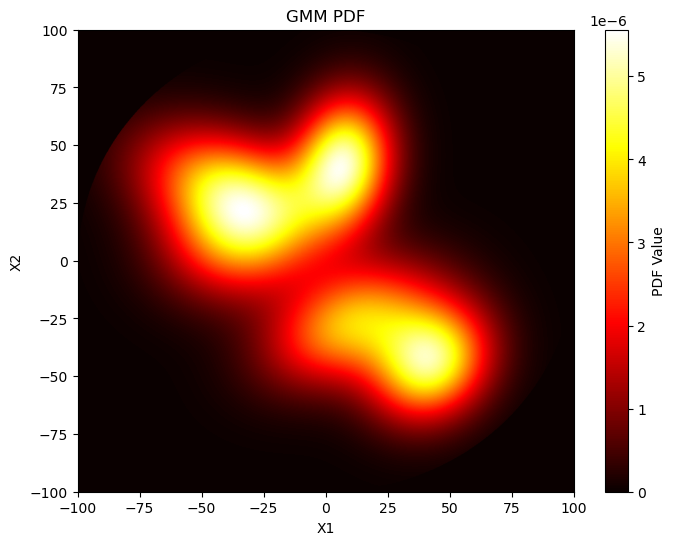

In [19]:
plot_2d_gmm_pdf(source_sampler, truncated_radius, save_path = None)

In [20]:
auxiliary_measure_sampler_set = []
for auxiliary_seed in [1010, 1018, 1014, 1016, 1003]:
    auxiliary_measure_sampler = MixtureOfGaussians(dim)
    auxiliary_measure_sampler.random_components(num_components=5, uniform_weights = True, seed = auxiliary_seed)
    auxiliary_measure_sampler.set_truncation(truncated_radius)
    auxiliary_measure_sampler_set.append(auxiliary_measure_sampler)

In [21]:
# construct entropic_sampler
entropic_sampler = entropic_input_sampler(dim, num_measures, auxiliary_measure_sampler_set, source_sampler = source_sampler, n_k = 1000, seed = 120)

In [22]:
# generate strong convexity parameters of the mappings.
entropic_sampler.generate_strong_convexity_param()
print("strong convexity parameters all set.")

strong convexity parameters all set.


In [23]:
# assign theta
entropic_sampler.assign_theta()
print("theta all set.")

theta all set.


In [24]:
# generate Y matrices
entropic_sampler.generate_Y_matrices()
print("Y matrices all set.")

source sampling: 100%|██████████| 1000/1000 [00:00<00:00, 3734.88it/s]


Finished generating Y matrix for auxiliary measure 0


source sampling: 100%|██████████| 1000/1000 [00:00<00:00, 3596.24it/s]


Finished generating Y matrix for auxiliary measure 1


source sampling: 100%|██████████| 1000/1000 [00:00<00:00, 4297.20it/s]


Finished generating Y matrix for auxiliary measure 2


source sampling: 100%|██████████| 1000/1000 [00:00<00:00, 4051.46it/s]


Finished generating Y matrix for auxiliary measure 3


source sampling: 100%|██████████| 1000/1000 [00:00<00:00, 4305.90it/s]

Finished generating Y matrix for auxiliary measure 4
Y matrices all set.


In [25]:
import jax
jax.config.update("jax_enable_x64", True)

# generate g vectors
entropic_sampler.generate_g_vectors()
print("g vectors all set.")


source sampling: 100%|██████████| 1000/1000 [00:00<00:00, 3547.39it/s]


Finished generating g vector for auxiliary measure 0
Finished generating g vector for auxiliary measure 1
Finished generating g vector for auxiliary measure 2
Finished generating g vector for auxiliary measure 3
Finished generating g vector for auxiliary measure 4
g vectors all set.


In [ ]:
# generate smoothness parameters; this involves solving max eigen for each tilde_k
entropic_sampler.generate_smoothness_param()
print("smoothness parameters all set.")
print(entropic_sampler.smoothness_param_dict)

In [ ]:
# construct a surjective mapping to map component maps to their respective OT maps for generating input measures.
entropic_sampler.construct_surjective_mapping()
print("surjective mapping all set.")

In [ ]:
# generate A matrices
entropic_sampler.generate_A_matrices()
print("A matrices all set.")

In [ ]:
for key, value in entropic_sampler.surjective_mapping.items():
    print(key, ' : ', value)

A_matrices_dict = entropic_sampler.A_matrices_dict
sum_matrix = np.zeros((dim, dim))
for i in range(num_measures):
    sum_matrix += A_matrices_dict[i]
print(f"The sum of the matrices is {sum_matrix}.")

In [ ]:
def G_sample_save(G_samples_dict, accepted_G_samples, iter, save_pathname = None):

        # Save the generated samples from the G-mapping at each iteration;
        # "accepted_G_samples" is the accepted samples generated from the G-mapping at the current iteration;
        # "G_samples" is a dictinoary with keys corresponding to the iteration number and values corresponding to the generated samples at that iteration.

        G_samples_dict[f"iteration_{iter}"] = accepted_G_samples
        G_samples_json = {str(k): v.tolist() for k, v in G_samples_dict.items()}
        G_sample_dir = f"{save_pathname}/G_samples"
        os.makedirs(G_sample_dir, exist_ok=True)
        save_data(G_samples_json, G_sample_dir, f"G_samples.json")

def V_value_compute(V_values_dict, bary_samples, input_sample_collection, iter = None, save_pathname = None):
    # Compute the V-value (i.e.,\@ the weighted sum of the Wasserstein distances between the input measures and the generated samples)
    # Notice that when iter = None, this returns the true V_value given by the ground-truth barycenter;
    # Otherwise, it is the V_value returned by an approximated barycenter.
    # The input_sample_collection is a dictionary with k keys, each key corresponds to the samples from the k-th input measure.

    V_value = 0
    for measure_index in range(num_measures):
        input_samples = np.array(input_sample_collection[measure_index])
        V_value += W2_pot(input_samples, bary_samples)
    
    # normalize the V_value by the number of input measures
    V_value /= num_measures

    if iter is None:
        V_values_dict["true_V_value"] = V_value
    else:
        V_values_dict[f"iteration_{iter}"] = V_value
        
    if save_pathname != None:
        V_values_json = V_values_dict
        V_value_dir = f"{save_pathname}/V_values"
        os.makedirs(V_value_dir, exist_ok=True)
        save_data(V_values_json, V_value_dir, f"V_values.json")


def W2_to_true_bary_compute(W2_to_true_bary_dict, accepted_G_samples, bary_samples, iter, save_pathname = None):

    # Compute the Wasserstein distance between the generated samples from the G-mapping
    # and the barycenter samples at each iteration;
    # "accepted_G_samples" is the accepted samples generated from the G-mapping at the current iteration;
    # "bary_samples" is the barycenter samples generated from the input measure at the current iteration;

    W2_sq = W2_pot(accepted_G_samples, bary_samples)
    W2_to_true_bary_dict[f"iteration_{iter}"] = W2_sq
    W2_to_true_bary_json = W2_to_true_bary_dict
    W2_to_true_bary_dir = f"{save_pathname}/W2_to_true_bary"
    os.makedirs(W2_to_true_bary_dir, exist_ok=True)
    save_data(W2_to_true_bary_json, W2_to_true_bary_dir, f"W2_to_true_bary.json")

In [ ]:
num_samples = 5000
result_dir = "results"
os.makedirs(result_dir, exist_ok=True)
save_pathname = f"{result_dir}/WIN_measures_{num_measures}_seed_{seed}_samples_{num_samples}_dim_{dim}"
os.makedirs(save_pathname, exist_ok=True)

In [ ]:
# source and input measures visualization
plot_dirc = f"{save_pathname}/plots"
os.makedirs(plot_dirc, exist_ok=True)

visualize_num_samples = 1000

source_measure_samples = source_sampler.sample(visualize_num_samples, multiplication_factor=1)
print("Start to plot the source measure")
plot_2d_source_measures_kde(source_measure_samples, plot_dirc = plot_dirc, scatter = False)
print("Finish plotting the input measures")

input_measure_samples = entropic_sampler.sample(visualize_num_samples, gamma = 0.5, manual = True)
for measure_index in range(num_measures):
    measure_samples = np.array(input_measure_samples[measure_index])
    print(f"Start to plot the input measure {measure_index}")
    plot_2d_input_measure_kde(measure_samples, measure_index, plot_dirc = plot_dirc, scatter = False)
    print(f"Finish plotting the input measure {measure_index}")


In [ ]:
G_samples_dict = {}
V_values_dict = {}
W2_to_true_bary_dict = {}

V_value_compute(V_values_dict, source_measure_samples, input_measure_samples, iter = None, save_pathname = save_pathname)

In [ ]:
while it < MAX_ITER:
    freeze(G)
    input_measure_samples_for_D = entropic_sampler.sample(BATCH_SIZE * D_ITERS)
    input_measure_samples_for_T_inv = entropic_sampler.sample(BATCH_SIZE * D_ITERS * T_ITERS)
    input_measure_samples_for_D_inv = entropic_sampler.sample(BATCH_SIZE * D_ITERS)
    # this is a dictionary with k keys, pointing to the samples collected from each measure
    for k in range(num_measures):
        # D and T optimization cycle
        for d_iter in tqdm(range(D_ITERS)):
            it += 1

            # T optimization
            unfreeze(Ts[k]); freeze(Ds[k])
            for t_iter in range(T_ITERS): 
                with torch.no_grad():
                    X = G(Z_sampler.sample(BATCH_SIZE))
                Ts_opt[k].zero_grad()
                T_X = Ts[k](X)
                T_loss = F.mse_loss(X, T_X).mean() - Ds[k](T_X).mean()
                T_loss.backward(); Ts_opt[k].step()
            del T_loss, T_X, X
            gc.collect()

            # D optimization
            with torch.no_grad():
                X = G(Z_sampler.sample(BATCH_SIZE))
            # Y = benchmark.samplers[k].sample(BATCH_SIZE)
            Y = torch.tensor(input_measure_samples_for_D[k][d_iter * BATCH_SIZE : (d_iter + 1) * BATCH_SIZE]).float()
            
            unfreeze(Ds[k]); freeze(Ts[k])
            T_X = Ts[k](X).detach()
            Ds_opt[k].zero_grad()
            D_loss = Ds[k](T_X).mean() - Ds[k](Y).mean()
            D_loss.backward(); Ds_opt[k].step()
            del D_loss, Y, X, T_X; gc.collect(); torch.cuda.empty_cache()
            
            # T inv optimization
            unfreeze(Ts_inv[k]); freeze(Ds_inv[k])
            for t_iter in range(T_ITERS): 
                Y = torch.tensor(input_measure_samples_for_T_inv[k][d_iter * T_ITERS * BATCH_SIZE + t_iter * BATCH_SIZE : d_iter * T_ITERS * BATCH_SIZE + (t_iter + 1) * BATCH_SIZE]).float()
                Ts_inv_opt[k].zero_grad()
                T_inv_Y = Ts_inv[k](Y)
                T_inv_loss = F.mse_loss(Y, T_inv_Y).mean() - Ds_inv[k](T_inv_Y).mean()
                T_inv_loss.backward(); Ts_inv_opt[k].step()
            del T_inv_loss, T_inv_Y, Y; gc.collect(); torch.cuda.empty_cache()

            # D inv optimization
            Y = torch.tensor(input_measure_samples_for_D_inv[k][d_iter * BATCH_SIZE : (d_iter + 1) * BATCH_SIZE]).float()
            with torch.no_grad():
                X = G(Z_sampler.sample(BATCH_SIZE))
            
            unfreeze(Ds_inv[k]); freeze(Ts_inv[k])
            T_inv_Y = Ts_inv[k](Y).detach()
            Ds_inv_opt[k].zero_grad()
            D_inv_loss = Ds_inv[k](T_inv_Y).mean() - Ds_inv[k](X).mean()
            D_inv_loss.backward(); Ds_inv_opt[k].step()
            del D_inv_loss, Y, X, T_inv_Y; gc.collect(); torch.cuda.empty_cache()

        
    # G optimization
    if G_ITERS > 0:
        for k in range(num_measures):
            freeze(Ts[k])
        G_old = deepcopy(G); freeze(G_old)
        unfreeze(G)
        for g_iter in range(G_ITERS):
            it += 1
            Z = Z_sampler.sample(BATCH_SIZE)
            with torch.no_grad():
                G_old_Z = G_old(Z)
                T_G_old_Z = torch.zeros_like(G_old(Z))
            G_old_Z.requires_grad_(True)
            for k in range(num_measures):
                T_G_old_Z += ALPHAS[k] * Ts[k](G_old_Z)

            G_opt.zero_grad()
            G_loss = .5 * F.mse_loss(G(Z), T_G_old_Z)
            G_loss.backward(); G_opt.step() 

            G_loss_history.append(G_loss.item())

        save_path = f"{save_pathname}/trained_models_iter_{it}"
        os.makedirs(save_path, exist_ok=True)
        models_to_save = {
            "G": G.state_dict(),
            "Ts": {k: Ts[k].state_dict() for k in range(num_measures)},
            "Ds": {k: Ds[k].state_dict() for k in range(num_measures)},
            # Save the inverse transforms if needed
            "Ts_inv": {k: Ts_inv[k].state_dict() for k in range(num_measures)},
            "Ds_inv": {k: Ds_inv[k].state_dict() for k in range(num_measures)},
        }

        # Save the dictionary
        torch.save(models_to_save, save_path)
        print(f"Models saved to {save_path}")

            # Log G_loss_history to a local file
        with open("G_loss_history.log", "a") as f:
            f.write(f"Iteration {it}, G_loss: {G_loss.item()}\n")

        del G_old, G_loss, T_G_old_Z, Z
        gc.collect()

        # Save the generated samples from the G-mapping at each iteration
        accepted_G_samples = G(Z_sampler.sample(num_samples)).detach().numpy()
        G_sample_save(G_samples_dict, accepted_G_samples, it, save_pathname = save_pathname)

        # Compute the V-value (i.e.,\@ the weighted sum of the Wasserstein distances between the input measures and the generated samples)
        # Notice that when iter = None, this returns the true V_value given by the ground-truth barycenter;
        V_value_compute(V_values_dict, accepted_G_samples, input_measure_samples, iter = it, save_pathname = save_pathname)

        # Compute the Wasserstein distance between the generated samples from the G-mapping
        # and the barycenter samples at each iteration;
        W2_to_true_bary_compute(W2_to_true_bary_dict, accepted_G_samples, source_measure_samples, it, save_pathname = save_pathname)

        # Plot the generated samples from the G-mapping at each iteration
        plot_2d_compare_with_source_kde(source_measure_samples, accepted_G_samples, it, plot_dirc = plot_dirc, scatter = False)
